In [58]:
import jax
from jax import numpy as jnp, random, jit, lax
from jax import grad, jit, vmap, pmap, value_and_grad

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt


In [ ]:
pip install flax

In [60]:
pip install optax

In [61]:
import flax
import optax

In [62]:
from flax import linen as nn

## Defining model

In [79]:
class SimpleClassifier(nn.Module):
    num_hidden1 : int   # Number of hidden neurons layer 1
    num_hidden2 : int   # number of hidden neurons layer 2
    num_outputs : int  # Number of output neurons

    def setup(self):
        # Create the modules we need to build the network
        # nn.Dense is a linear layer
        self.Relu = nn.relu
        self.sigmoid = nn.sigmoid
        self.linear1 = nn.Dense(features=self.num_hidden1)
        self.linear2 = nn.Dense(features= self.num_hidden2)
        self.linear3 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        
        x = self.linear1(x)
        x = self.Relu(x)
        # x = self.linear2(x)
        # x = self.sigmoid(x)
        # x = nn.log_sigmoid(x)
        x = self.linear3(x)
        # x = nn.tanh(x)
        # x = nn.relu(x)
        # x = nn.swish(x)
        return x



## Loss function

In [80]:
# loss using tensor flow probability distribution 
@jit
def loss_tfp(theta, x, y):
    out = model.apply(theta, x)
    y_hat = out[:, 0] 
    var = jnp.exp(out[:,1]) 

    dist = tfp.distributions.Normal(y_hat, jnp.sqrt(var))
    res = -jnp.mean(dist.log_prob(y)) 
    return res 


## Learning noise for Homoscedastic data

In [105]:

# x = jnp.linspace(-10, 10, 100).reshape(100,1)
x = jnp.linspace(-2,2, 100)
mu = 0
std = 0.5
key = jax.random.PRNGKey(5)
# es = mu + std * jax.random.normal(key, (100,1)
es = mu + std * jax.random.normal(key, x.shape)
y = es  + x**2


# Initializing model
model = SimpleClassifier(num_hidden1 = 15, num_hidden2 = 4,  num_outputs = 2)


rng = jax.random.PRNGKey(10)
rng, inp_rng, init_rng = jax.random.split(rng, 3)

inp = jax.random.normal(inp_rng, (10,1)) #batchsize = 10, input size = 1
params = model.init(init_rng, inp) # key , input

opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(params)


epochs = 1000
loss_lis = []

for i in range(1, epochs+1):
  loss, grad = jax.value_and_grad(loss_tfp)(params, x.reshape(100,1), y)
  loss_lis.append(loss)
  update , opt_state = opt.update(grad, opt_state)
  
  params = optax.apply_updates(params, update)
  if i %500==0 or i==1:
    print('epoch ', i,' loss ', loss)

epoch  1  loss  1.8965247
epoch  500  loss  0.7123544
epoch  1000  loss  0.69945586


Text(0.5, 1.0, 'Loss vs epochs')

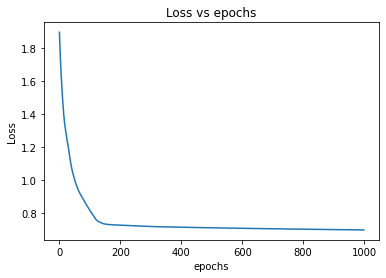

In [106]:
ep_lis = [i for i in range(epochs)]
plt.plot(ep_lis, loss_lis)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss vs epochs')

Text(0, 0.5, 'y')

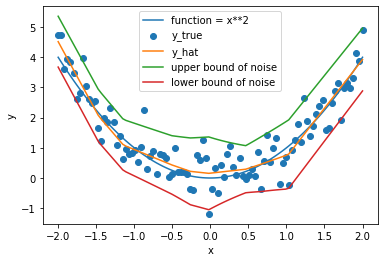

In [107]:
out = model.apply(params, x.reshape((100,1)))
y_hat = out[:,0]
var = out[:,1]
var = jnp.exp(out[:, 1])
plt.plot(x, x**2, label='function = x**2')
plt.scatter(x,y, label='y_true')
plt.plot(x, y_hat, label='y_hat')
plt.plot(x,y_hat+2*jnp.sqrt(var), label= 'upper bound of noise')
plt.plot(x,y_hat-2*jnp.sqrt(var), label='lower bound of noise')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

## Learning noise for heteroscedastic  data

In [108]:

# x = jnp.linspace(-10, 10, 100).reshape(100,1)
x = jnp.linspace(-2,2, 100)
mu = 0
std = 0.5
key = jax.random.PRNGKey(5)
# es = mu + std * jax.random.normal(key, (100,1)
es = mu + std * jax.random.normal(key, x.shape)
y = es*x  + x**2 


# Initializing model
model = SimpleClassifier(num_hidden1 = 10, num_hidden2 = 4,  num_outputs = 2)


rng = jax.random.PRNGKey(10)
rng, inp_rng, init_rng = jax.random.split(rng, 3)

inp = jax.random.normal(inp_rng, (10,1)) #batchsize = 10, input size = 1
params = model.init(init_rng, inp) # key , input

opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(params)


epochs = 1000
loss_lis = []

for i in range(1, epochs+1):
  loss, grad = jax.value_and_grad(loss_tfp)(params, x.reshape(100,1), y)
  loss_lis.append(loss)
  update , opt_state = opt.update(grad, opt_state)
  
  params = optax.apply_updates(params, update)
  if i %500==0 or i==1:
    print('epoch ', i,' loss ', loss)

epoch  1  loss  4.9075074
epoch  500  loss  0.59164286
epoch  1000  loss  0.47172183


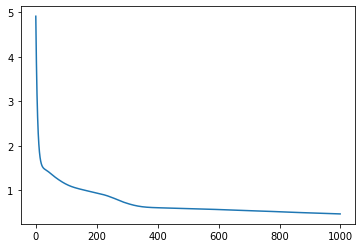

In [109]:
ep_lis = [i for i in range(epochs)]
plt.plot(ep_lis, loss_lis)

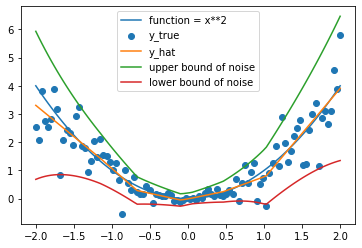

In [110]:
out = model.apply(params, x.reshape((100,1)))
y_hat = out[:,0]
var = out[:,1]
var = jnp.exp(out[:, 1])


plt.plot(x, x**2, label='function = x**2')
plt.scatter(x,y, label='y_true')
plt.plot(x, y_hat, label='y_hat')
plt.plot(x,y_hat+2*jnp.sqrt(var), label= 'upper bound of noise')
plt.plot(x,y_hat-2*jnp.sqrt(var), label='lower bound of noise')
plt.legend()
